# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step -1: Import dependencies

In [1]:
# Import dependencies
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import math
import random
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.utils import shuffle
from skimage import transform as transf
from sklearn.model_selection import train_test_split
from IPython.display import display
import time as time
from datetime import datetime
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

RAND_SEED = 20

## Step 0: Load The Data

In [2]:
# Load pickled data

training_file = 'data/traffic-signs-data/train.p'
testing_file = 'data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
features_train, labels_train = train['features'], train['labels']
features_test, labels_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.


# TODO: Number of training examples
n_train = len(features_train)

# TODO: What's the shape of an traffic sign image?
_, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = features_train.shape
image_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)


# TODO: How many unique classes/labels there are in the dataset.
with open('signnames.csv', 'r') as sign_name:
    reader = csv.reader(sign_name)
    sign_names = list(reader)

sign_names = sign_names[1::] # Remove csv header
NUM_CLASSES = len(sign_names)
print('Total number of classes: {}'.format(NUM_CLASSES))

n_classes = len(np.unique(labels_train))
assert (NUM_CLASSES == n_classes), '1 or more class(es) not represented in training set'

# TODO: Number of testing examples.
n_test = len(labels_test)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Total number of classes: 43
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
# Data exploration: Visualization
def visualise_random_images(num_rows, num_cols, X_dataset, y_dataset):
    
    plt.figure(figsize = (10, 8))
    # Use GridSpec to easily create a grid of images with spacing
    gs = gridspec.GridSpec(num_rows, num_cols)
    gs.update(wspace=0.2, hspace=0.01)
    
    for i in range(num_rows * num_cols):
        splot = plt.subplot(gs[i])
        plt.axis('on')
        # No ticks in the subplots
        splot.set_xticklabels([])
        splot.set_yticklabels([])
        # Choose label at random from y_dataset
        idx_rand = np.random.randint(1, len(y_dataset))
        plt.imshow(X_dataset[idx_rand])
        plt.annotate(str(y_dataset[idx_rand]), xy=(2, 5), color='red', fontsize='14')
        plt.axis("off")
    plt.show()

In [5]:
# def visualise_random_images_gray(num_rows, num_cols, X_dataset, y_dataset):
    
#     print(X_dataset.shape)
    
#     plt.figure(figsize = (10, 8))
#     # Use GridSpec to easily create a grid of images with spacing
#     gs = gridspec.GridSpec(num_rows, num_cols)
#     gs.update(wspace=0.2, hspace=0.01)
    
#     for i in range(num_rows * num_cols):
#         splot = plt.subplot(gs[i])
#         plt.axis('on')
#         # No ticks in the subplots
#         splot.set_xticklabels([])
#         splot.set_yticklabels([])
#         # Choose label at random from y_dataset
#         idx_rand = np.random.randint(1, len(y_dataset))
#         plt.imshow(X_dataset[idx_rand], cmap='gray')
#         plt.annotate(str(y_dataset[idx_rand]), xy=(2, 5), color='red', fontsize='14')
#         plt.axis("off")
#     plt.show()

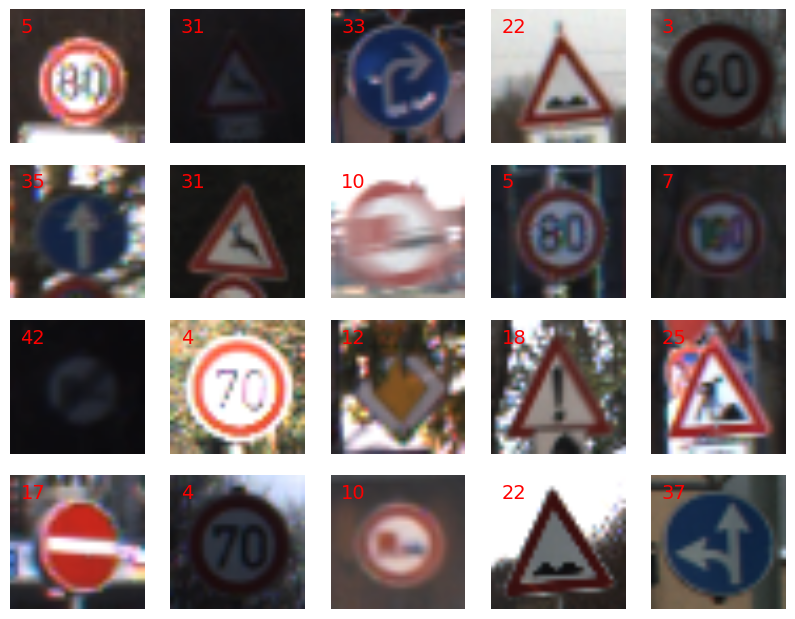

In [6]:
# Visualise 20 examples selected randomly from the training dataset
visualise_random_images(4, 5, features_train, labels_train)

In [7]:

# DATA EXPLORATION: Pixel intensity distribution
def pick_random_images_from_class(classid, num_images=5, channel=-1):
    # Sanity checks
    assert channel < 3, 'Channel should be between 0 and 2'
    assert (np.sum(labels_train==classid)) >= num_images, 'Reduce number of images.'
    
    # Find all images with the selected class
    all_images = np.ravel(np.argwhere(labels_train==classid))
    # Pick 5 images randomly
    rand_image_ids =  np.random.choice(all_images, size=num_images, replace=False)
    rand_images = features_train[rand_image_ids, :, :, :] if channel < 0 else features_train[rand_image_ids, :, :, channel]
    return rand_image_ids, rand_images

def pixel_intensity_dist(classid, channel, hist_labels_max=50, num_images=5, preprocess=False):
    # Sanity checks
    assert channel < 3, 'Channel should be between 0 and 2'
    
    rand_image_ids, rand_images = pick_random_images_from_class(classid, num_images, channel)
    print('Showing pixel distribution of channel {} for {} image(s) from the class {}...'
          .format(channel, num_images, classid))
    
    plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(num_images, 2)
    gs.update(wspace=0.001, hspace=0.2)
    
    for i in range(num_images):
        # Plot image
        splot = plt.subplot(gs[i, 0]) # First col of grid
        # No ticks in the subplots
        splot.set_xticklabels([])
        splot.set_yticklabels([])
        
        if preprocess:
            rand_images[i] = cv2.equalizeHist(rand_images[i])
        
        plt.imshow(rand_images[i], cmap='gray') # Change to grayscale for easily visualisation
        plt.axis('off')
        # Plot histogram
        splot = plt.subplot(gs[i, 1]) # Second col of grid
        splot.hist(np.histogram(rand_images[i], bins=256), bins=256)
        splot.set_xlim([0, 100])
        splot.set_ylim([0, hist_labels_max])
        
    plt.show()
#pixel_intensity_dist(classid=10, channel=1)

### Before equalising image
Showing pixel distribution of channel 2 for 5 image(s) from the class 10...


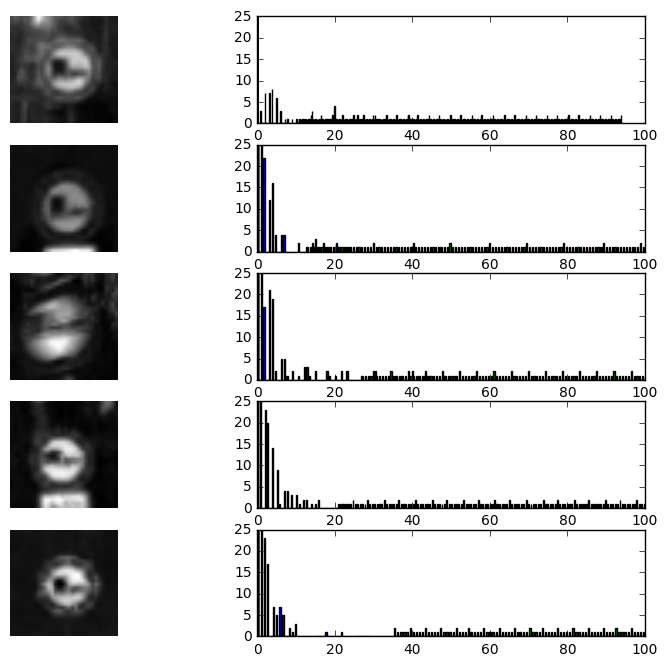

In [8]:
print("### Before equalising image")
# np.random.seed(5)
pixel_intensity_dist(classid=10, channel=2, hist_labels_max=25)

### After equalising image
Showing pixel distribution of channel 2 for 5 image(s) from the class 10...


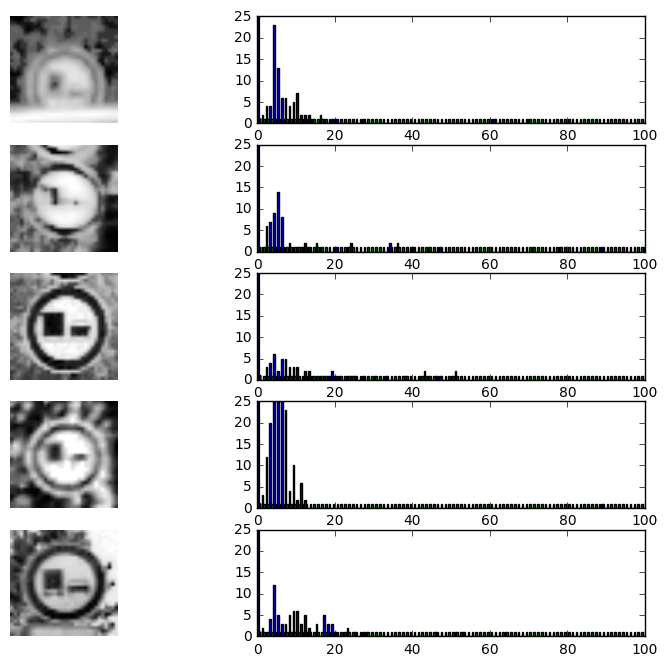

In [9]:
print("### After equalising image")
# np.random.seed(5)
pixel_intensity_dist(classid=10, channel=2, hist_labels_max=25, preprocess=True)

## Observations

From the above analysis of the dataset, I noticed variations between the images.
- Brightness and contrast are not uniform.
- The background of the signs are varied in colour and content. 
- The size of the traffic sign are varied compared to the size of the image.
- The histogram distribution of the images from the same class are very different.
- Distribution of the labels are not uniform. Some signs occur more frequently than others as will be discussed in other steps below.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def preprocess_image(image, display_images = False):
    # image_eq = image
    # Histogram equalisation to remove effect 
    # image_eq = np.empty(image.shape, dtype=image.dtype)
    image_eq = cv2.equalizeHist(image)
    
    #Normalise the values
    image_norm = image_eq/255.0 - 0.5
    
    if display_images:
        # Plot the results
        fig = plt.figure()

        grid = plt.subplot(1, 3, 1)
        grid.set_title('Original Image')
        grid.imshow(image, cmap='gray')
        
        grid = plt.subplot(1, 3, 2)
        grid.set_title('Equalised Histogram')
        grid.imshow(image_eq, cmap='gray')

        grid = plt.subplot(1, 3, 3)
        grid.set_title('Normalized')
        grid.imshow(image_norm, cmap='gray')

        plt.tight_layout()
        plt.show()
    
    return image_norm


def preprocess_dataset(dataset):
    n_imgs, img_height, img_width, _ = dataset.shape
    processed_dataset = np.zeros((n_imgs, img_height, img_width, 1))
    #print("dataset.shape: {}, processed_dataset.shape: {}".format(dataset.shape, processed_dataset.shape))
    for i in range(len(dataset)):
        img = dataset[i]
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        processed_dataset[i, :, :, 0] = preprocess_image(gray)
    return processed_dataset

(32, 32)


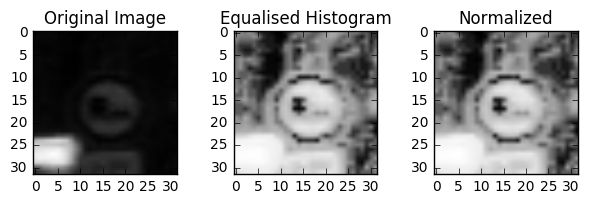

In [11]:
# np.random.seed(5)
rand_img_ids, rand_images = pick_random_images_from_class(10, 1)
for img in rand_images:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    __ = preprocess_image(gray, True)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
Preprocessing of the data were done in the following steps:
- Original RGB images were converted to Grayscale.
- Histogram equalisation was applied on the grayscale image so that the effect of brightness is removed and improves the contrast in the image by broadening the distribution of the histogram. 
- Scaling the images between -0.5 and 0.5, dividing by 255 i.e. the maximum pixel intensity available in RGB colour space, and subtracting 0.5. This helps normalise the pixel intensities of the dataset but preserving any variation in the histogram from image to image. 

In [12]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def transform_image(image, angle, shear, translation):
    
    # Rotation
    ang_rot = np.random.uniform(angle) - angle/2
    rows, cols, color_channels = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), ang_rot, 1)
    # Translation
    trans_x = translation*np.random.uniform() - translation/2
    trans_y = translation*np.random.uniform() - translation/2
    translation_matrix = np.array([[1, 0, trans_x], [0, 1, trans_y]]).astype('float32')
    # Shearing
    pts1 = np.array([[5, 5], [20, 5], [5, 20]]).astype('float32')
    pt1 = 5 + shear*np.random.uniform() - shear/2
    pt2 = 20 + shear*np.random.uniform() - shear/2
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    shear_matrix = cv2.getAffineTransform(pts1, pts2)
    # Affine Transformation: Rotation + Translation + Shearing
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    image = cv2.warpAffine(image, shear_matrix, (cols, rows))
    
    return image

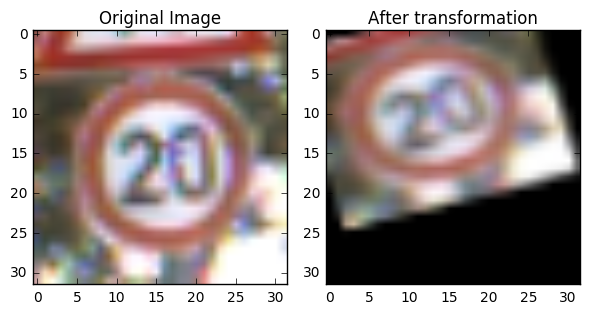

In [13]:
orig_image = features_train[n_classes, ...]
# Rotate image 
transformed = transform_image(orig_image, 20, 10, 5)

splot = plt.subplot(1, 2, 1)
splot.set_title('Original Image')
plt.imshow(orig_image, cmap='gray')

splot = plt.subplot(1, 2, 2)
splot.set_title('After transformation')
plt.imshow(transformed, cmap='gray')

plt.tight_layout()

In [14]:
def augment_synthetic_data(features_data, labels_data, expand_to):
    n_classes = len(np.unique(labels_data))
    _, img_height, img_width, img_depth = features_data.shape

    # Number of images per class
    imgs_per_class = np.zeros(n_classes)
    for cls in range(n_classes):
        imgs_per_class[cls] = np.sum(labels_data == cls)

    # Expand current class to expand_to images
    new_images_per_class = expand_to - imgs_per_class
    total_new_images = np.sum(new_images_per_class)

    # Initialize datastructure to store new images with expanded dimension
    features_new = np.zeros((int(total_new_images), img_height, img_width, img_depth), dtype=features_data.dtype)
    labels_new = np.zeros(int(total_new_images))

    start_id = 0

    print('features_data: {}, Augmenting synthetic data...'.format(features_data.shape))

    for cur_class in range(n_classes):
        # Number of new images to generate of this current class
        n_new_imgs = new_images_per_class[cur_class]
        end_id = start_id + n_new_imgs
    
        # Get ids of all images that belongs to cur_class
        all_imgs_id = np.argwhere(labels_data == cur_class)
        # Store all the new images of this current class 
        new_imgs_cur_class = np.zeros((int(n_new_imgs), img_height, img_width, img_depth))
    
        for cur_new_img_id in range(int(n_new_imgs)):
            # Pick a random original image that belongs to cur_class:
            rand_id = np.random.choice(all_imgs_id[0], size=None, replace=True)
            rand_img = features_data[rand_id]
            # Do random image transform
            new_img = transform_image(rand_img, 20, 10, 5)
            new_imgs_cur_class[cur_new_img_id, :, :, :] = new_img
        
        # Update new datastructure with images and its correct labels
        features_new[int(start_id) : int(end_id)] = new_imgs_cur_class
        labels_new[int(start_id) : int(end_id)] = np.ones((int(n_new_imgs),)) * cur_class
        start_id = end_id

    features_train_augmented = np.concatenate((features_data, features_new.astype('uint8')), axis=0)
    labels_train_augmented = np.concatenate((labels_data, labels_new), axis=0)
    
    print('Total new images added to dataset: {}, features_train_augmented: {}'.format(int(total_new_images), 
                                                                                features_train_augmented.shape))

    del features_new, labels_new  # Free up some memory

    return [features_train_augmented, labels_train_augmented]


In [15]:
# Shuffle train dataset before splitting
features_train, labels_train = shuffle(features_train, labels_train)
_, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = features_train.shape

# Split into train and validation set with ratio 80-20
# Train/Validation split must be done before data augmentation so that validation set 
# has images similar to test set (no synthetic images)
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, 
                                                                                        labels_train, 
                                                                                        test_size=0.20, 
                                                                                        random_state=RAND_SEED)
print('Training set size: {} | Validation set size: {}'.format(features_train.shape[0], features_validation.shape[0]))

# Run data augmentation on Train set to have uniform distribution of class
features_train_augmented, labels_train_augmented = augment_synthetic_data(features_train, labels_train, expand_to=4000)

Training set size: 31367 | Validation set size: 7842
features_data: (31367, 32, 32, 3), Augmenting synthetic data...
Total new images added to dataset: 140633, features_train_augmented: (172000, 32, 32, 3)


In [16]:
# Data Exploration: class distribution
def class_distribution(labels):
    label, count = np.unique(labels, return_counts=True)
    label_freq = np.array((label, count)).T
    # Sort by frequency
    label_freq_sorted = sorted(label_freq, key=lambda col: col[1])
    # Use pandas lib to read sign names into data frame and integrate frequency. 
    df_cdist = pd.read_csv('signnames.csv')
    df_cdist['Frequency'] = pd.Series(np.asarray(label_freq).T[1], index=np.array(label_freq_sorted).T[0])
    df_cdist = df_cdist.sort_values(by=['Frequency'], ascending=[False]).reset_index().drop('index', 1)
    return (label, df_cdist)

In [17]:
augmented_train_clabel, augmented_train_df_cdist = class_distribution(labels_train_augmented)
display(augmented_train_df_cdist)
# # Visualise class distribution
# fig = plt.figure(figsize=(8, 4))
# plt.bar(augmented_train_clabel, height=augmented_train_df_cdist["Frequency"])

ClassId                                           SignName  Frequency
0         0                               Speed limit (20km/h)     4000.0
1        32                End of all speed and passing limits     4000.0
2        24                          Road narrows on the right     4000.0
3        25                                          Road work     4000.0
4        26                                    Traffic signals     4000.0
5        27                                        Pedestrians     4000.0
6        28                                  Children crossing     4000.0
7        29                                  Bicycles crossing     4000.0
8        30                                 Beware of ice/snow     4000.0
9        31                              Wild animals crossing     4000.0
10       33                                   Turn right ahead     4000.0
11       22                                         Bumpy road     4000.0
12       34                                    Turn left ahead     4000.0
13       35                                         Ahead only     4000.0
14       36                               Go straight or right     4000.0
15       37                                Go straight or left     4000.0
16       38                                         Keep right     4000.0
17       39                                          Keep left     4000.0
18       40                               Roundabout mandatory     4000.0
19       41                                  End of no passing     4000.0
20       23                                      Slippery road     4000.0
21       21                                       Double curve     4000.0
22        1                               Speed limit (30km/h)     4000.0
23       10       No passing for vehicles over 3.5 metric tons     4000.0
24        2                               Speed limit (50km/h)     4000.0
25        3                               Speed limit (60km/h)     4000.0
26        4                               Speed limit (70km/h)     4000.0
27        5                               Speed limit (80km/h)     4000.0
28        6                        End of speed limit (80km/h)     4000.0
29        7                              Speed limit (100km/h)     4000.0
30        8                              Speed limit (120km/h)     4000.0
31        9                                         No passing     4000.0
32       11              Right-of-way at the next intersection     4000.0
33       20                       Dangerous curve to the right     4000.0
34       12                                      Priority road     4000.0
35       13                                              Yield     4000.0
36       14                                               Stop     4000.0
37       15                                        No vehicles     4000.0
38       16           Vehicles over 3.5 metric tons prohibited     4000.0
39       17                                           No entry     4000.0
40       18                                    General caution     4000.0
41       19                        Dangerous curve to the left     4000.0
42       42  End of no passing by vehicles over 3.5 metric ...     4000.0

ClassId                                           SignName  Frequency
0        34                                    Turn left ahead        451
1        42  End of no passing by vehicles over 3.5 metric ...        431
2        16           Vehicles over 3.5 metric tons prohibited        424
3        29                                  Bicycles crossing        420
4        24                          Road narrows on the right        420
5         2                               Speed limit (50km/h)        406
6        27                                        Pedestrians        356
7        32                End of all speed and passing limits        349
8        14                                               Stop        319
9         0                               Speed limit (20km/h)        317
10       41                                  End of no passing        298
11       21                                       Double curve        283
12       39                                          Keep left        278
13       40                               Roundabout mandatory        261
14        5                               Speed limit (80km/h)        260
15       22                                         Bumpy road        241
16        6                        End of speed limit (80km/h)        234
17       20                       Dangerous curve to the right        161
18        9                                         No passing        149
19        3                               Speed limit (60km/h)        143
20       18                                    General caution        133
21       36                               Go straight or right        120
22       33                                   Turn right ahead        108
23       35                                         Ahead only        102
24       19                        Dangerous curve to the left         87
25       26                                    Traffic signals         86
26        8                              Speed limit (120km/h)         81
27        4                               Speed limit (70km/h)         77
28       23                                      Slippery road         77
29       25                                          Road work         75
30       11              Right-of-way at the next intersection         71
31       10       No passing for vehicles over 3.5 metric tons         68
32       30                                 Beware of ice/snow         68
33       15                                        No vehicles         65
34       12                                      Priority road         60
35       28                                  Children crossing         50
36        1                               Speed limit (30km/h)         50
37        7                              Speed limit (100km/h)         46
38       17                                           No entry         46
39       37                                Go straight or left         46
40       31                              Wild animals crossing         45
41       38                                         Keep right         40
42       13                                              Yield         40

<Container object of 43 artists>

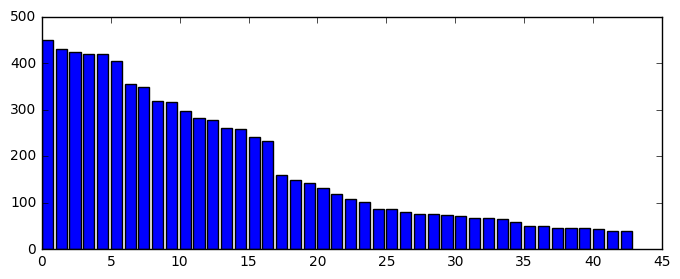

In [18]:
validation_clabel, validation_df_cdist = class_distribution(labels_validation)
display(validation_df_cdist)
# Visualise class distribution
fig = plt.figure(figsize=(8, 3))
plt.bar(validation_clabel, height=validation_df_cdist["Frequency"])

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
- The original dataset was split by 80% into training and 20% into validation sets using train_test_split function from sklearn lib.
- Since the number of images per label was not uniform and because the training set size was too small to sufficiently train a convolutional network, all labels were expanded up to 4000 examples by synthetically generated data using augment_synthetic_data() function below.
- As part of augmenting synthetic data, the image jittering was performed. For this affine transformation was applied:  where the images were rotated by random number generated between +/- 20 degrees, translated by +/-5 pixels along both vertical and horizontal directions, and finally sheared by +/-10 pixels. This was to ensure sufficient resiliency and affine invarience when evaluated against unknown test data. Choice of rotation angle was chosen keeping in mind that too much rotation could change the meaning of some traffic signs such as that having arrows. At the same time, it would benefit from being rotation invariant to a certain degree.

In [19]:
def plot_loss(summary_train):
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    plt.subplots_adjust(wspace = .2)
    for i in range(len(ax)):
        ax[i].tick_params(axis='x', labelsize=12)
        ax[i].tick_params(axis='y', labelsize=12)
        ax[i].xaxis.label.set_fontsize(12)
        ax[i].yaxis.label.set_fontsize(12)
        
    marker_size = 8
    ax[0].plot(summary_train[:,0], summary_train[:,1], 'b-o', markersize=marker_size, label='Train')
    ax[0].plot(summary_train[:,0], summary_train[:,2], 'r-o', markersize=marker_size, label='Validation')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[1].semilogy(summary_train[:,0], summary_train[:,3], 'b-o', markersize=marker_size, label='Train')
    ax[1].semilogy(summary_train[:,0], summary_train[:,4], 'r-o', markersize=marker_size, label='Validation')

    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[2].semilogy(summary_train[:,0], summary_train[:,3]/summary_train[:,4], 'k-o', markersize=marker_size, label='Train')

    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Training/Validation')
    
    plt.show()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The final architecture is a ConvNet consisting of two parts:
- Three convolutional blocks, each composed of two sub-blocks of: a convolutional layer, a ReLU activation function (to prevent gradient vanishing in deep neural networks), and a dropout layer (to force the network find generalised representations) connected in series. The end of each of the three convolutional block ended with a 2x2 max pooling operation (just before the dropout operation).
- A block of two fully connected layers, each followed by a ReLU activation function and a dropout layer.

In [20]:
# Remove previous Tensors and Operations
tf.reset_default_graph()

# Initialization functions for convolutional network
def init_weights(shape, mean, stddev, name, seed=RAND_SEED):
    init = tf.truncated_normal(shape, mean=mean, stddev=stddev, seed=seed, name=name+'_tnorm')
    return tf.Variable(init, name=name)
 
def init_bias(shape, init, name):
    init = tf.constant(init, shape=shape, name=name+'_const')
    return tf.Variable(init, name=name)

def conv_layer(x, W, strides, padding, name):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding, name=name)

def max_pool(x, padding, name):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=padding, name=name)

In [21]:
# Weights and biases
IMG_DEPTH = 1
mu = 0
sigma = 0.05
bias_init = 0.05

weights = {  
    'conv1_w': init_weights([3, 3, IMG_DEPTH, 80], mean=mu, stddev=sigma, name='conv1_w'),
    'conv2_w': init_weights([3, 3, 80, 120], mean=mu, stddev=sigma, name='conv2_w'),
    'conv3_w': init_weights([4, 4, 120, 180], mean=mu, stddev=sigma, name='conv3_w'),
    'conv4_w': init_weights([3, 3, 180, 200], mean=mu, stddev=sigma, name='conv4_w'),
    'conv5_w': init_weights([3, 3, 200, 200], mean=mu, stddev=sigma, name='conv5_w'),
    'fc1_w': init_weights([800, 80], mean=mu, stddev=sigma, name='fc1_w'),
    'fc2_w': init_weights([80, 80], mean=mu, stddev=sigma, name='fc2_w'),
    'fc3_w': init_weights([80, 43], mean=mu, stddev=sigma, name='fc3_w'),
}

biases = {
    'conv1_b': init_bias(shape=[80], init=bias_init, name='conv1_b'),
    'conv2_b': init_bias(shape=[120], init=bias_init, name='conv2_b'),
    'conv3_b': init_bias(shape=[180], init=bias_init, name='conv3_b'),
    'conv4_b': init_bias(shape=[200], init=bias_init, name='conv4_b'),
    'conv5_b': init_bias(shape=[200], init=bias_init, name='conv5_b'),
    'fc1_b': init_bias([80], init=bias_init, name='fc1_b'),
    'fc2_b': init_bias([80], init=bias_init, name='fc2_b'),
    'fc3_b': init_bias([43], init=bias_init, name='fc3_b'),
}

In [22]:
def conv_model(input, keep_prob, keep_prob_conv, weights, biases):    

    # Convolutional layer 1
    conv1 = conv_layer(input, weights['conv1_w'], strides=[1, 1, 1, 1], padding='VALID', name='conv1_op')
    conv1_activ = tf.nn.relu(conv1 + biases['conv1_b'], name='conv1_activ')
    conv1_drop = tf.nn.dropout(conv1_activ, keep_prob=keep_prob_conv, name='conv1_drop')
    # Convolutional layer 2
    conv2 = conv_layer(conv1_drop, weights['conv2_w'], strides=[1, 1, 1, 1], padding='SAME', name='conv2_op')
    conv2_activ = tf.nn.relu(conv2 + biases['conv2_b'], name='conv2_activ')
    conv2_pool = max_pool(conv2_activ, padding='VALID', name='conv2_pool')
    pool2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob_conv, name='conv2_drop')
    # Convolutional layer 3
    conv3 = conv_layer(pool2_drop, weights['conv3_w'], strides=[1, 1, 1, 1], padding='VALID', name='conv3_op')
    conv3_activ = tf.nn.relu(conv3 + biases['conv3_b'], name='conv3_activ')
    conv3_drop = tf.nn.dropout(conv3_activ, keep_prob=keep_prob_conv, name='conv3_drop')
    # Convolutional layer 4
    conv4 = conv_layer(conv3_drop, weights['conv4_w'], strides=[1, 1, 1, 1], padding='SAME', name='conv4_op')
    conv4_activ = tf.nn.relu(conv4 + biases['conv4_b'], name='conv4_activ')
    conv4_pool = max_pool(conv4_activ, padding='VALID', name='conv4_pool')
    conv4_drop = tf.nn.dropout(conv4_pool, keep_prob, name='conv4_drop')
    # Convolutional layer 5
    conv5 = conv_layer(conv4_drop, weights['conv5_w'], strides=[1, 1, 1, 1], padding='VALID', name='conv5_op')
    conv5_activ = tf.nn.relu(conv5 + biases['conv5_b'], name='conv5_activ')
    conv5_pool = max_pool(conv5_activ, padding='VALID', name='conv5_pool')
    conv5_drop = tf.nn.dropout(conv5_pool, keep_prob, name='conv5_drop')
    # Fully connected layer 1
    fc0 = flatten(conv5_drop)
    fc1 = tf.nn.relu(tf.matmul(fc0, weights['fc1_w']) + biases['fc1_b'], name='fc1')
    fc1_drop = tf.nn.dropout(fc1, keep_prob, name='fc1_drop')
    # Fully connected layer 2
    fc2 = tf.nn.relu(tf.matmul(fc1_drop, weights['fc2_w']) + biases['fc2_b'], name='fc2')
    fc2_drop = tf.nn.dropout(fc2, keep_prob, name='fc2_drop')
    logits = tf.add(tf.matmul(fc2_drop, weights['fc3_w']), biases['fc3_b'], name='logits')  

    return [weights, logits]

In [23]:
### Train your model here.
### Feel free to use as many code cells as needed.
features = tf.placeholder(tf.float32, (None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), name='features')
labels = tf.placeholder(tf.int32, (None), name='labels')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
keep_prob_conv = tf.placeholder(tf.float32, name='keep_prob_conv')
one_hot_labels = tf.one_hot(labels, n_classes, name='one_hot')
rate = tf.placeholder(tf.float32, name='rate')

weights, logits = conv_model(features, keep_prob,  keep_prob_conv, weights, biases)
softmax_operation = tf.nn.softmax(logits, name='softmax')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_labels, name='softmax_cross_entropy')
beta = 0.0001
loss_reg = beta * (tf.nn.l2_loss(weights['fc1_w']) + tf.nn.l2_loss(weights['fc2_w']) + tf.nn.l2_loss(weights['fc3_w']))
loss = tf.reduce_mean(cross_entropy, name='reduce_mean') + loss_reg

optimizer = tf.train.AdamOptimizer(learning_rate = rate, name='optimizer')
training_operation = optimizer.minimize(loss, name='training_operation')

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_labels, 1), name='correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')

def evaluate(features_data, labels_data):
    num_examples = len(features_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    total_l = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        # end = end if (end <= last_index) else last_index
        batch_features, batch_labels = features_data[offset:end], labels_data[offset:end]
        accuracy, l = sess.run([accuracy_operation, loss], 
                               feed_dict={features: batch_features, 
                                          labels: batch_labels, 
                                          keep_prob_conv: 1.0, 
                                          keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_features))
        total_l += (l * len(batch_features))
    return [total_accuracy/num_examples, total_l/num_examples]

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
- AdamOptimzer was used as the optimizer of choice in order to minimise the loss function because it is more efficient than stochastic gradient descent. 
- Batch size of 200 images as a balance between training being too slow versus memory consumption. Also, the validation accuracy of the model decreased when it was too large.
- Weights were initialised using a truncated Gaussian distribution with mean (mu) of 0 and standard deviation (sigma) of 0.05. If sigma is too low or too high, the model would hardly show any improvement (loss would go down very slowly or not at all) in learning during training. 
- Learning rate was set to 0.01 as a balance between too high whereby model doesn't learn or too low where the convergence takes forever. 
- Model was trained for only 25 Epochs but was surprisingly sufficient to produce good training and validation accuracies of 0.9995 and 0.9954 respectively. Initially, the model was train up to 65 epochs however, due to a bug in restoring the saved model, I couldn't afford to use too much time on the cloud GPU. 
- Dropout layers with keep rate of 0.5 was used for fully connected layers, while less agressive dropout was used with a keep rate of 0.6 for convolutional layers.
- Max pooling was used to decrease the size of the output and prevent overfitting.
- L2 regularisation was applied to the weights of fully connected layers to prevent overfitting.
- The resulting plots shown below track the accuracy and the loss of the training and validation sets in each epoch during training. Loss of training set is 10 times smaller than the validation set. Last plot is the Loss ratio of Training and Validation which is observed to remain constant at higher epochs. 

Training...
Pre-processing training data...
features_train pre-processed datatset size: (172000, 32, 32, 1) | dtype: float64
Pre-processing validation data...
features_validation pre-processed datatset size: (7842, 32, 32, 1) | dtype: float64
Evaluating training data...
Evaluating validation data...
--- EPOCH 1 ---
Train accuracy: 0.8549 | Validation accuracy = 0.3834
Train loss: 0.59661 | Validation loss = 2.09311
Model conv_model_j_0 saved.


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Evaluating training data...
Evaluating validation data...
--- EPOCH 2 ---
Train accuracy: 0.9203 | Validation accuracy = 0.6245
Train loss: 0.26502 | Validation loss = 1.21617
Evaluating training data...
Evaluating validation data...
--- EPOCH 3 ---
Train accuracy: 0.9486 | Validation accuracy = 0.7256
Train loss: 0.16893 | Validation loss = 0.80441
Evaluating training data...
Evaluating validation data...
--- EPOCH 4 ---
Train accuracy: 0.9648 | Validation accuracy = 0.8066
Train loss: 0.12771 | Validation loss = 0.59867
Evaluating training data...
Evaluating validation data...
--- EPOCH 5 ---
Train accuracy: 0.9753 | Validation accuracy = 0.8531
Train loss: 0.09650 | Validation loss = 0.45231
Evaluating training data...
Evaluating validation data...
--- EPOCH 6 ---
Train accuracy: 0.9874 | Validation accuracy = 0.9239
Train loss: 0.06536 | Validation loss = 0.26984
Evaluating training data...
Evaluating validation data...
--- EPOCH 7 ---
Train accuracy: 0.9912 | Validation accuracy =

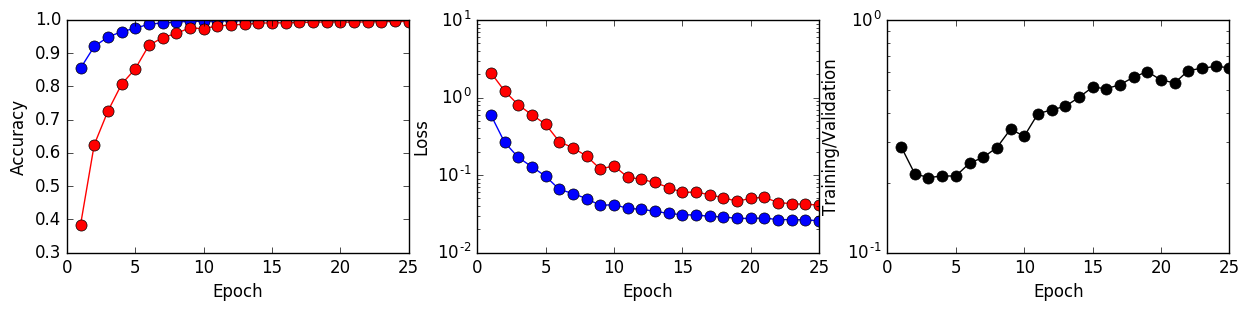

In [28]:
EPOCHS = 25
BATCH_SIZE = 200
model_version = 'j'
keep_rate = 0.5
keep_rate_shallow = 0.6
learn_rate = 1e-3

saver = tf.train.Saver()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    summary_train = []
    
    print('Pre-processing training data...')
    features_train_processed = preprocess_dataset(features_train_augmented)

    print('features_train pre-processed datatset size: {} | dtype: {}'.format(features_train_processed.shape, 
                                                                               features_train_processed.dtype))

    print('Pre-processing validation data...')
    features_val_processed = preprocess_dataset(features_validation)

    print('features_validation pre-processed datatset size: {} | dtype: {}'.format(features_val_processed.shape, 
                                                                                    features_val_processed.dtype))
    start_time = time.time()
    
    labels_train_processed = None
    
    for i in range(EPOCHS):
        # Randomise training dataset before training
        if labels_train_processed is None:
            # first time only
            features_train_processed, labels_train_processed = shuffle(features_train_processed, labels_train_augmented)
        else:
            features_train_processed, labels_train_processed = shuffle(features_train_processed, labels_train_processed)
        
        # Train processed data
        num_examples = len(features_train_processed)
        # last_index = num_examples - 1
        
        # Train model in batches
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            # end = end if (end <= last_index) else last_index
            batch_features, batch_labels = features_train_processed[offset:end], labels_train_processed[offset:end]
            sess.run(training_operation, feed_dict={features: batch_features, 
                                                    labels: batch_labels, 
                                                    keep_prob_conv: keep_rate_shallow, 
                                                    keep_prob: keep_rate,
                                                    rate: learn_rate})
        
        # Evaluate against training data
        print('Evaluating training data...')
        train_accuracy, train_loss = evaluate(features_train_processed, labels_train_processed)
        # Evaluate against validation data
        print('Evaluating validation data...')
        validation_accuracy, validation_loss = evaluate(features_val_processed, labels_validation)

        print("--- EPOCH {} ---".format(i+1))
        print("Train accuracy: {:.4f} | Validation accuracy = {:.4f}".format(train_accuracy, validation_accuracy))
        print("Train loss: {:.5f} | Validation loss = {:.5f}".format(train_loss, validation_loss))

        summary_train.append([i+1, train_accuracy, validation_accuracy, train_loss, validation_loss])
        
        cur_time_diff = str((time.time() - start_time) / 60.0)
        # Example: '2017-01-03 17:45:35.177000'
        cur_summary_train = np.array([i+1, train_accuracy, validation_accuracy, 
                                     train_loss, validation_loss, 
                                     str(datetime.now()), cur_time_diff])
        np.save('cur_summary_train_' + model_version + '.npy', cur_summary_train)
        
        if (i % 10) == 0:
            model_filename = 'conv_model_' + model_version + '_' + str(i)
            saver.save(sess, model_filename)
            print("Model {} saved.".format(model_filename))
            
    end_time = time.time()
    time_diff = end_time - start_time
    
    print('Time taken: {} seconds = {} minutes'.format(time_diff, time_diff / 60.0))
    summary_train = np.array(summary_train)
    np.save('summary_train_' + model_version + '.npy', summary_train)

    saver.save(sess, 'conv_model_' + model_version + '_final')
    print('Final Model saved.')

    # Plot loss
    plot_loss(summary_train)

In [ ]:
# Plot loss
summary_train_loaded = np.load('summary_train_j.npy')
plot_loss(summary_train_loaded)

In [ ]:
# from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
# # List ALL tensors.
# print_tensors_in_checkpoint_file(file_name='./conv_model_j_final', tensor_name='')

# for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
#     print(v)

In [30]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# import tensorflow as tf
# tf.reset_default_graph()
model_file = 'conv_model_j_final'
BATCH_SIZE = 200

saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './' + model_file)
    
    print('Pre-processing training data...')
    features_train_processed = preprocess_dataset(features_train_augmented)
    print('features_train pre-processed datatset size: {} | dtype: {}'.format(features_train_processed.shape, 
                                                                              features_train_processed.dtype))
    print('Pre-processing validation data...')
    features_val_processed = preprocess_dataset(features_validation)
    print('features_validation pre-processed datatset size: {} | dtype: {}'.format(features_val_processed.shape, 
                                                                                   features_val_processed.dtype))
    print('Pre-processing test data...')
    features_test_processed = preprocess_dataset(features_test)
    print('features_test pre-processed datatset size: {} | dtype: {}'.format(features_test_processed.shape, 
                                                                             features_test_processed.dtype))
    start_time = time.time()
    
    # Randomise training dataset before training
#     features_train_processed, labels_train_processed = shuffle(features_train_processed, labels_train_augmented)
    
    # Evaluate against training data
#     train_accuracy, train_loss = evaluate(features_train_processed, labels_train_processed)
    train_accuracy, train_loss = evaluate(features_train_processed, labels_train_augmented)

    # Evaluate against validation data
    validation_accuracy, validation_loss = evaluate(features_val_processed, labels_validation)
    # Evaluate against test data
    test_accuracy, test_loss = evaluate(features_test_processed, labels_test)

    print("Train accuracy: {:.4f} | Validation accuracy = {:.4f} | Test accuracy = {:.4f}".format(train_accuracy, 
                                                                                                  validation_accuracy, 
                                                                                                  test_accuracy))
    print("Train loss: {:.5f} | Validation loss = {:.5f}| Test loss = {:.5f}".format(train_loss, 
                                                                                     validation_loss, 
                                                                                     test_loss))

    # Select 20 random images only instead of the whole features_test to prevent overflowing GPU for softmax_op
    rand_imgs = [random.randint(0, len(labels_test)) for i in range(20)]
    features_test_select = np.zeros((20, IMG_HEIGHT, IMG_WIDTH, 1))
    labels_test_select = np.zeros((20, 1))
    for i in range(len(rand_imgs)):
        features_test_select[i] = features_test_processed[rand_imgs[i]]
        labels_test_select = labels_test[rand_imgs[i]]
        
    test_prediction_prob = sess.run(softmax_operation, feed_dict={features: features_test_select, 
                                                                  keep_prob_conv: 1.0, 
                                                                  keep_prob: 1.0})
    prediction_test = np.argmax(test_prediction_prob, 1)
    
    end_time = time.time()
    time_diff = end_time - start_time
    
    print('Time taken: {} seconds = {} minutes'.format(time_diff, time_diff/60.0))

Pre-processing training data...
features_train pre-processed datatset size: (172000, 32, 32, 1) | dtype: float64
Pre-processing validation data...
features_validation pre-processed datatset size: (7842, 32, 32, 1) | dtype: float64
Pre-processing test data...
features_test pre-processed datatset size: (12630, 32, 32, 1) | dtype: float64
Train accuracy: 0.9995 | Validation accuracy = 0.9954 | Test accuracy = 0.9717
Train loss: 0.02574 | Validation loss = 0.04125| Test loss = 0.15737
Time taken: 103.95264482498169 seconds = 1.7325440804163614 minutes


In [ ]:
# plt.figure()
# img1 = features_train_processed[2304, :, :, 0]
# plt.imshow(img1, cmap='gray')

In [ ]:
# # Continue training from where we stopped earlier...
# epochs_start = 25
# epochs_end = 50

# BATCH_SIZE = 200
# model_version = 'j'
# keep_rate = 0.5
# keep_rate_shallow = 0.6
# learn_rate = 1e-4

# model_file = 'conv_model_' + model_version + '_final'
# summary_file = 'summary_train_' + model_version + '.npy'

# # model_file = 'conv_model_h_final'
# # model_file = 'conv_model_e_final_422.763980170091.meta'

# with tf.Session() as sess:
    
#     sess.run(tf.global_variables_initializer())
#     saver = tf.train.Saver()
#     saver.restore(sess, './' + model_file)
    
#     num_examples = len(features_train_augmented)
    
#     print("Training...")
#     summary_train = np.load(summary_file).tolist()
    
#     print('Pre-processing training data...')
#     features_train_processed = preprocess_dataset(features_train_augmented)

#     print('features_train pre-processed datatset size: {} | dtype: {}'.format(features_train_processed.shape, 
#                                                                               features_train_processed.dtype))

#     print('Pre-processing validation data...')
#     features_val_processed = preprocess_dataset(features_validation)

#     print('features_validation pre-processed datatset size: {} | dtype: {}'.format(features_val_processed.shape, 
#                                                                                    features_val_processed.dtype))
#     start_time = time.time()
    
#     for i in range(epochs_start, epochs_end):
        
#         # Randomise training dataset before training
#         features_train_processed, labels_train_processed = shuffle(features_train_processed, labels_train_augmented)
        
#         # Train processed data
#         num_examples = len(features_train_processed)
#         # last_index = num_examples - 1
        
#         # Train model in batches
#         for offset in range(0, num_examples, BATCH_SIZE):
#             end = offset + BATCH_SIZE
#             # end = end if (end <= last_index) else last_index
#             batch_features, batch_labels = features_train_processed[offset:end], labels_train_processed[offset:end]
#             sess.run(training_operation, feed_dict={features: batch_features, 
#                                                     labels: batch_labels, 
#                                                     keep_prob_conv: keep_rate_shallow, 
#                                                     keep_prob: keep_rate,
#                                                     rate: learn_rate})
        
#         # Evaluate against training data
#         print('Evaluating training data...')
#         train_accuracy, train_loss = evaluate(features_train_processed, labels_train_processed)
#         # Evaluate against validation data
#         print('Evaluating validation data...')
#         validation_accuracy, validation_loss = evaluate(features_val_processed, labels_validation)

#         print("--- EPOCH {} ---".format(i+1))
#         print("Train accuracy: {:.4f} | Validation accuracy = {:.4f}".format(train_accuracy, validation_accuracy))
#         print("Train loss: {:.5f} | Validation loss = {:.5f}".format(train_loss, validation_loss))
#         summary_train.append([i+1, train_accuracy, validation_accuracy, train_loss, validation_loss])
        
#         cur_time_diff = str((time.time() - start_time) / 60.0)
#         # Example: '2017-01-03 17:45:35.177000'
#         cur_summary_train = np.array([i+1, train_accuracy, validation_accuracy, 
#                                      train_loss, validation_loss, 
#                                      str(datetime.now()), cur_time_diff])
#         np.save('cur_summary_train_' + model_version + '.npy', cur_summary_train)
        
#         if (i % 10) == 0:
#             try:
#                 saver
#             except NameError:
#                 saver = tf.train.Saver()
#             model_filename = 'conv_model_' + model_version + '_' + str(i)
#             saver.save(sess, model_filename)
#             print("Model {} saved.".format(model_filename))
        
#     end_time = time.time()
#     time_diff = end_time - start_time
    
#     print('Time taken: {} seconds = {} minutes'.format(time_diff, time_diff / 60.0))
#     summary_train = np.array(summary_train)
#     np.save('summary_train_' + model_version + '.npy', summary_train) 
#     try:
#         saver
#     except NameError:
#         saver = tf.train.Saver()
#     saver.save(sess, 'conv_model_' + model_version + '_final')
#     print('Final Model saved.')

#     # Plot loss
#     plot_loss(summary_train)

**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I researched various image identification algorithms by researchers and experimented with different types of models such as linear, fully connected network, convolutional layer. I also read a lot of discussions from the forums and that probably biased me towards using convolutional networks. The convolutional networks gave the best mix of accuracy and speed of training. 

For the convolutional network, I started with one convolutional layer, and a fully connected layer and reached validation of about 0.8. I increased the depth and width of the network and found the performance of the model improving significantly through a bit of trail and error. 

I also experimented with leaky ReLU activation function because of some references indicating that standard ReLU units being fragile and irreversibly die during training. However, I could not find any noticeable difference during training of my model and perhaps due to frequent bugs, I went back to standard ReLU to keep it simple. 

I included dropout and L2-regularisation primarily because of prior research into its advantages of preventing overfitting. 

I spent a lot of time with input in RGB colour space assuming that the network would be able to find an efficient represention of colour space by itself. However, due to model accuracy, I pre-processed the images to grayscale and found that model accuracy increased by a few points and at the same time make training faster. I found that pre-processing and augmenting randomly varying affine transformations to be the equally time consumming and crucial stage to get the accuracy higher. 

The result of my final convolutional model trained only for 25 epochs is as follows:
* Train accuracy: 0.9995
* Validation accuracy = 0.9954
* Test accuracy = 0.9717

On testing the model on 20 random test images below, we can see that it incorrectly labeled Roundbout manadory (40) as Speed limit 100km/h (7). This is probably because of the image contains half a sign at the top of the roundabout sign and probably was confused. However, the model works quite effectively even for dark or blurred images. Therefore, my implementation is suitable for the current problem. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

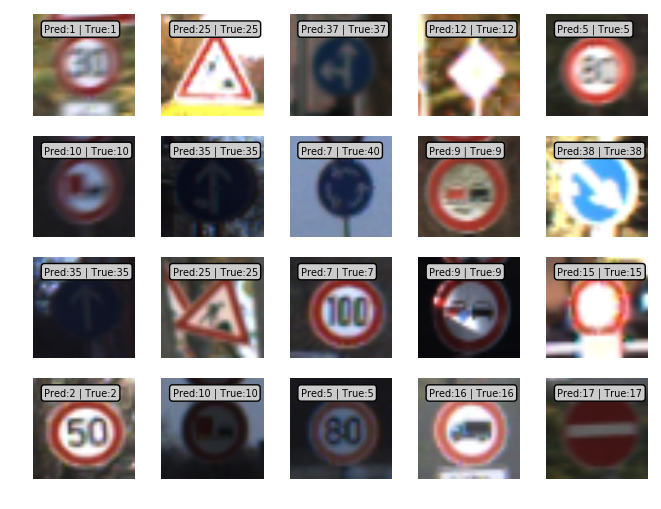

In [40]:
_, ax = plt.subplots(len(rand_imgs)//5, 5, figsize=(8, 6))
row, col = 0, 0
for i, idx in enumerate(rand_imgs):
    img =  features_test[idx]
    ax[row, col].imshow(img, cmap='gray')
    annot = 'Pred:'+str( int(prediction_test[i])) +' | True:'+ str(labels_test[idx])
    ax[row, col].annotate(annot, xy=(3, 5), color='black', fontsize='7', bbox=dict(boxstyle="round", fc="0.8"))

    ax[row,col].axis('off')
    col += 1
    if col == 5:
        row += 1
        col = 0
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The 30 images of 10 different labels of varying frequencies, were real images taken from Karlsruhe, Germany. One of the images were taken in very high side angle. The 30 speed limit was different because it has the word 'Zone' in it which was not available in any of the training sets. One of the 'No Entry' signs is slightly occluded by some leaves in front of it.

In [ ]:
# ## Saving new images to pickle file.
# ## The images are manually labelled.
# ## The order of the images is not guaranteed to be the same

# %matplotlib inline

# image_file_paths = listdir('test_images')

# images = []
# for path in image_file_paths:
#     images.append(mpimg.imread('%s%s' % ('test_images/', path)))
    
# new_signs_img = np.zeros([len(images),32,32,3],dtype=np.uint8)
# new_signs_label = np.array([28,2,22,22,36,
#                             13,17,1,1,17,
#                             25,38,25,31,35,
#                             22,25,36,38,38,
#                             17,22,35,12,33,
#                             38,38,25,38
#                            ],dtype=np.uint8)

# with open('signnames.csv', 'r') as csvfile:
#     signnames = csv.reader(csvfile, delimiter=',')
#     next(signnames,None)
#     for row in signnames:
#         signs.append(row[1])
#     csvfile.close()

# plt.figure(figsize=(20,20))
# for id,img in enumerate(images):
#     images[id] = cv2.resize(img,dsize=(32,32))
#     new_signs_img[id] = images[id]
#     sub = plt.subplot(6,5,id+1)
#     plt.imshow(new_signs_img[id])
#     sub.set_title("%s, %s" % (signs[new_signs_label[id]], new_signs_label[id]))

# pickle_file = 'new_signs.p'
# if not os.path.isfile(pickle_file):
#     print('Saving data to pickle file...')
#     try:
#         with open('new_signs.p', 'wb') as pfile:
#             pickle.dump(
#                 {
#                     'data': new_signs_img,
#                     'labels': new_signs_label,
#                 },
#                 pfile, pickle.HIGHEST_PROTOCOL)
#     except Exception as e:
#         print('Unable to save data to', pickle_file, ':', e)
#         raise

# print('Data cached in pickle file.')

In [97]:
# Data exploration: Visualization
def visualise_images(num_rows, num_cols, X_dataset, y_dataset):
    
    plt.figure(figsize = (10, 8))
    # Use GridSpec to easily create a grid of images with spacing
    gs = gridspec.GridSpec(num_rows, num_cols)
    gs.update(wspace=0.1, hspace=0.2)
    
    for i in range(len(X_dataset)):
        splot = plt.subplot(gs[i])
        plt.axis('on')
        # No ticks in the subplots
        splot.set_xticklabels([])
        splot.set_yticklabels([])
        # Choose label at random from y_dataset
        if X_dataset.shape[3] == 1:
            plt.imshow(X_dataset[i, :, :, 0], cmap='gray')
        else:
            plt.imshow(X_dataset[i])
        plt.annotate(str(y_dataset[i]), xy=(2, 5), color='red', fontsize='14')
        plt.axis("off")
    plt.show()

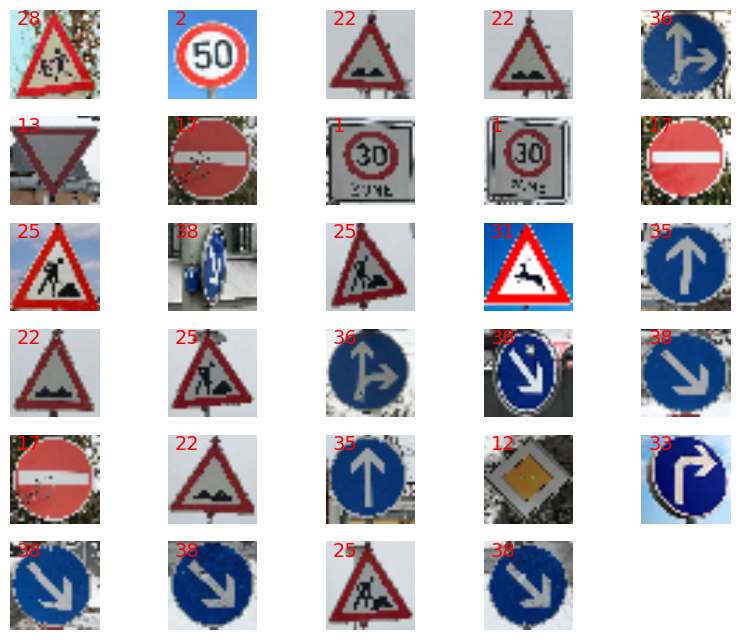

In [98]:
## Load new images from pickle file
%matplotlib inline
new_signs_file = "new_signs.p"
with open(new_signs_file, mode='rb') as f:
    new_signs = pickle.load(f)
    f.close()

features_new = new_signs['data']
labels_new = new_signs['labels']

visualise_images(6, 5, features_new, labels_new)

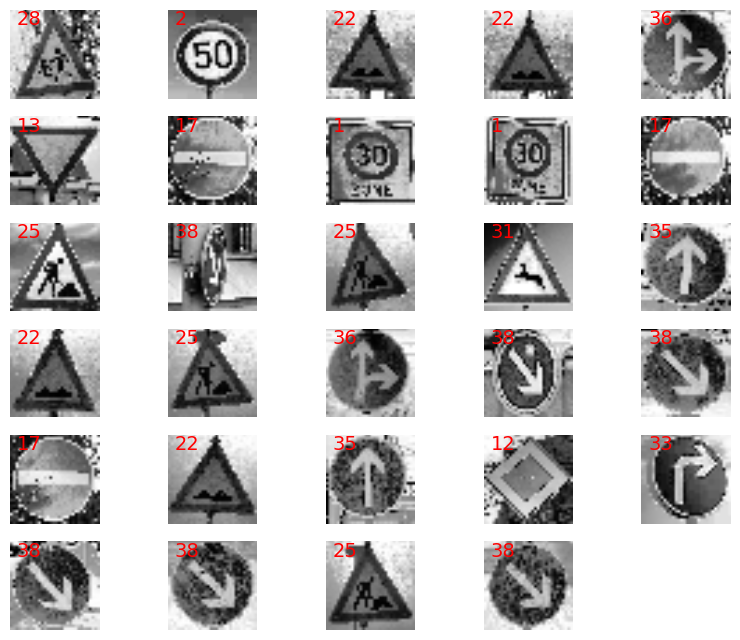

In [99]:
# Pre-processing
features_new_processed = preprocess_dataset(features_new)
visualise_images(6, 5, features_new_processed, labels_new)

Prediction on new data


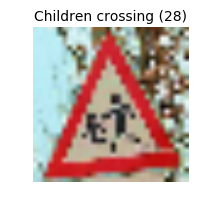

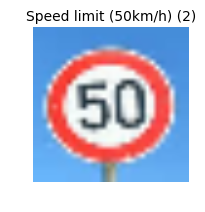

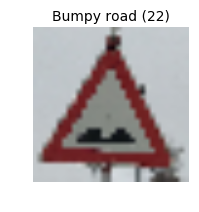

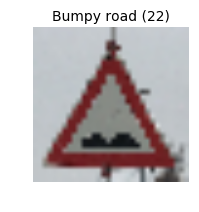

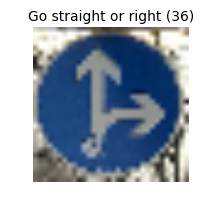

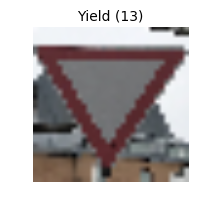

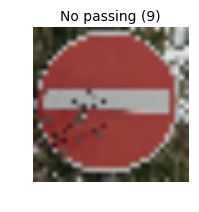

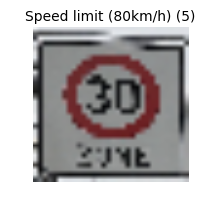

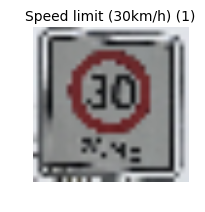

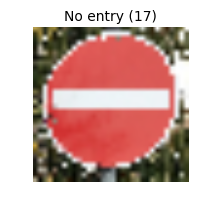

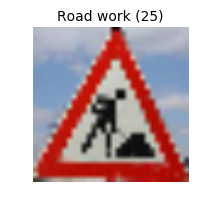

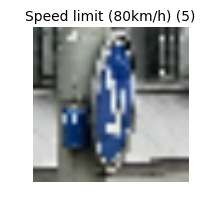

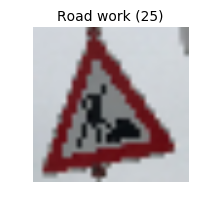

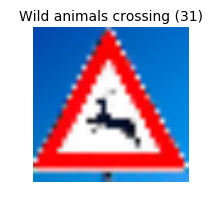

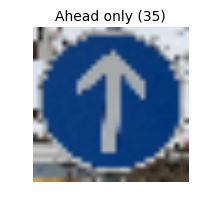

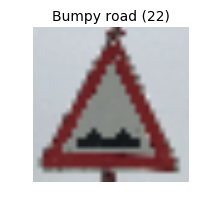

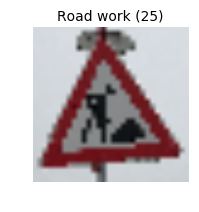

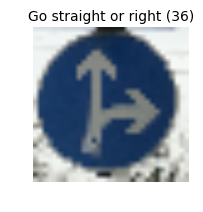

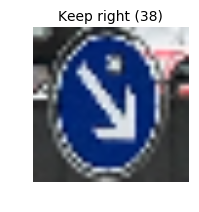

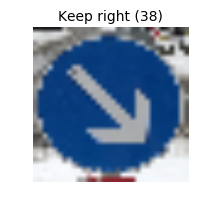

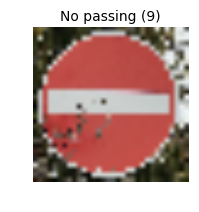

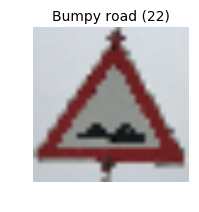

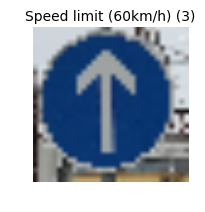

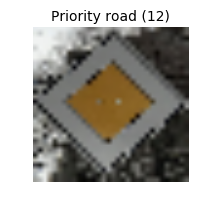

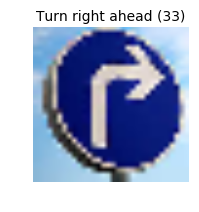

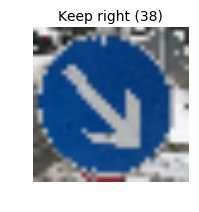

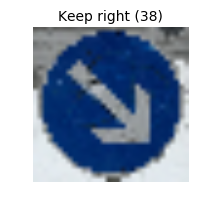

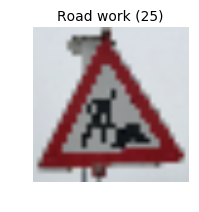

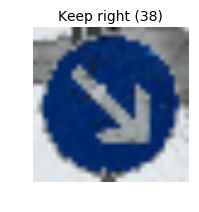

In [118]:
### Inference
k_top = 5
model_file = 'conv_model_j_final'

feed_dict = {features: features_new_processed, keep_prob: 1.0, keep_prob_conv: 1.0}

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './' + model_file)
    prediction_prob = sess.run(softmax_operation, feed_dict=feed_dict)
    prediction = np.argmax(prediction_prob, 1)
    # Top 5 probabilities
    top_k_values = tf.nn.top_k(softmax_operation, k_top)
    top_k_proba = sess.run([softmax_operation, top_k_values], feed_dict=feed_dict)

### Feel free to use as many code cells as needed.

# Visualize image with predicted label
print('Prediction on new data')
for i in range(len(features_new)):
    plt.figure(figsize=(2, 2))
    img = features_new[i]
    plt.imshow(img)
    plt.title("{} ({})".format(sign_names[prediction[i]][1], prediction[i]), fontsize=10)
    plt.axis('off')
    plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

As shown in the output images above, the images were manually labelled and saved to a pickel file. Since there were 5 incorrect classifications out of 30 new test images, the accuracy of the model is 83.33%. 

Accuracy of my newly captured images is 83.33% while it was 97.17% on the testing dataset derived from the German Traffic Signs dataset earlier. Thus it seems to indicate that my model may be overfitting to a certain extent. However, certain factors such as leaves occluding some signs and in the background, or the fact that some images were not even part of any label in the training dataset, or taken at high angle, could be contributing to the drop in accuracy. These factors have a greater effect on the new accuracy as the new test size is very small (30). It would be interesting to experiment with a larger number of new test images to be sure.

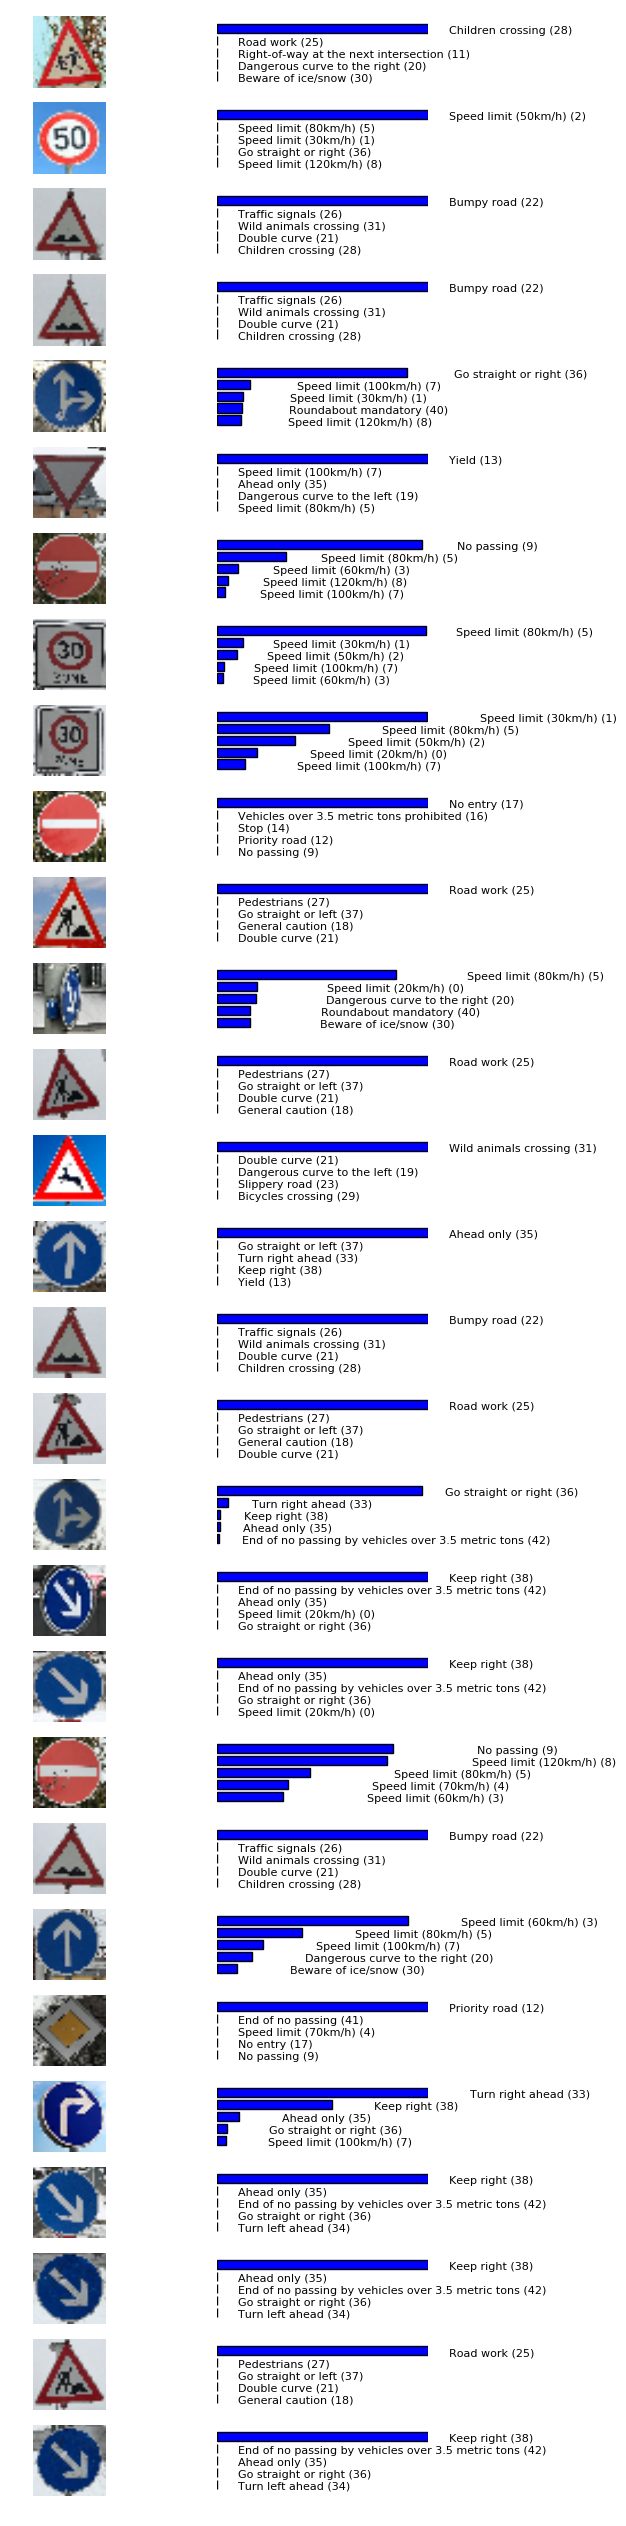

In [117]:
### TOP 5 PROBABILITIES: CERTAINTIES

#initialize subplots
_, ax = plt.subplots(len(features_new), 2, figsize=(6, 32))
col_plot = 0
for i in range(len(features_new)):
    img = features_new[i]
    ax[i, col_plot].imshow(img)
    ax[i,col_plot].axis('off')
    col_plot += 1
    ax[i, col_plot].barh(-np.arange(k_top), top_k_proba[1][0][i], align='center')
    
    # Annotations
    for k in range(k_top):
        text_pos = [top_k_proba[1][0][i][k]+.1, -(k+0.4)]
        ax[i, col_plot].text(text_pos[0], text_pos[1], 
                             "{} ({})".format(sign_names[top_k_proba[1][1][i][k]][1], 
                                              sign_names[top_k_proba[1][1][i][k]][0]), 
                             fontsize=8)
    ax[i,col_plot].axis('off')
    col_plot = 0
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:**

For the incorrect classifications, the model is not very certain for that label as there are other labels competing for the decision. 

The incorrect labels were as follows:
* Incorrectly classified _**"No entry" (17)**_ as _**"No passing" (9)**_. This is probably due to the presence of background leaves as well as occluding leaves blocking the sign. 
* Incorrectly classified _**"Speed limit (30km/h)" (1)**_ as _**"Speed limit (80km/h)" (5)**_. This is probably due to the presence of text 'Zone' which is not part of any training dataset. 
* Incorrectly classified _**"Keep Right" (38)**_ as _**"Speed limit (80km/h)" (5)**_. This was quite challenging as the image was taken from the side at a high angle. 
* Again incorrectly classified _**"No entry" (17)**_ as _**"No passing" (9)**_. This is probably due to the presence of background leaves as well as occluding leaves blocking the sign. 
* Incorrectly classified _**"Ahead only" (35)**_ as _**"Speed limit (60km/h)" (3)**_. This could be due to the background noise. 


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Future improvements
- As traffic signs are designed for humans, and colour is an important component of classification, consider converting RGB images to YUV or LAB colour space so that the colour is more representative of human perception than RGB. Perhaps including grayscale as the fourth channel would help classify even better.
- Create a second output for the "category" of the traffic sign such as Danger/warning, Priority, Infomation, Direction, Position, etc. and weight the loss function based on the sign category.